### First raw analysis

In [2]:
%run 60_testing_different_sf.ipynb

data_folder = ..\Psychopy_data\exp\sf_0


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier tmp existe d‚j….
Une erreur s'est produite lors du traitement deÿ: tmp.


Overwriting tmp/60_testing_different_sf.py


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier ..\Psychopy_data\exp\sf_0 existe d‚j….
Une erreur s'est produite lors du traitement deÿ: ..\Psychopy_data\exp\sf_0.



 Initializing
B_thetas =  [0.20943951 0.41887902 0.62831853 0.83775804 1.04719755]
sfs =  [0.125      0.04419417 0.015625   0.00552427 0.00195312]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
subj_name_list =  ['MP','HL','JF','CR','JM']
subj_data_list = []
import json
for subject in subj_name_list :
    x = json.load(open(os.path.join(data_folder, 'Psychophys_discrim_%s.json' % subject), 'rb'))
     #changer et mettre le path du fichier où se trouve les psychophysic data
    subj_data_list.append(x)

In [29]:
B_theta_list = []
for x in subj_data_list[0] :
    B_theta_list.append(x[3]*180/np.pi)
B_theta_list = sorted(set(B_theta_list))

print('B_theta_list=', B_theta_list)
sf_list = []
for x in subj_data_list[0] :
    sf_list.append(x[4])
sf_list = sorted(set(sf_list))
print('sf_list=', sf_list)

B_theta_list= [12.0, 24.0, 36.0, 48.0, 59.99999999999999]
sf_list= [0.001953125, 0.005524271728019903, 0.015625, 0.04419417382415922, 0.125]


### Correct responses

In [30]:
data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    data_dict[num]['correct'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        #print(i, item)
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(B_theta_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0
        data_dict[num]['correct'][0, i] = (item[1]>0) if item[2] == 'right' else (item[1]<0)     
    correct = data_dict[num]['correct'].mean()
    print(f'Subject {num} has {correct*100:.3f} % correct overall')

Subject 0 has 67.467 % correct overall
Subject 1 has 67.067 % correct overall
Subject 2 has 74.933 % correct overall
Subject 3 has 73.333 % correct overall
Subject 4 has 74.800 % correct overall


In [31]:
data_dict[num]['correct'].reshape((5, 5, 30)).shape

(5, 5, 30)

## Fit

In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = len(sf_list)*len(B_theta_list)
bias = True
logit0_init, theta0_init, log_wt_init = -np.log(1/.10 - 1), 0.0, np.log(4.)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 12 + 1

def fit_data(logistic_model,
    theta, ind_condition, y,
    learning_rate=learning_rate,
    # batch_size=batch_size,  # previous notebook showed that learning_rate had no influence on performance
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []    
            
     
    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    logistic_model.cpu()
    return logistic_model, loss        

In [33]:
bias = False
#bias = True
logit0_init = logit0_init * torch.ones(1)
# indep = logit0_init=logit0_init * torch.ones(int(len(data)/len(B_theta_list)/len(B_sf_list)))
results = {}
for num, data in enumerate(subj_data_list) :
    logistic_model = LogisticRegressionModel(logit0_init * torch.ones(1), theta0_init*torch.ones(N_conditions), torch.log(log_wt_init*torch.ones(N_conditions)), bias=bias)
    logistic_model, loss = fit_data(logistic_model, data_dict[num]['theta'], 
                                    data_dict[num]['conditions'], 
                                    data_dict[num]['response'], verbose=True)
    results[num] = logistic_model
    print("Final loss =", loss)

Iteration: 0 - Loss: 662.58667
Iteration: 128 - Loss: 543.07430
Iteration: 256 - Loss: 471.13397
Iteration: 384 - Loss: 439.97818
Iteration: 512 - Loss: 428.51041
Iteration: 640 - Loss: 423.89309
Iteration: 768 - Loss: 421.49734
Iteration: 896 - Loss: 419.94744
Iteration: 1024 - Loss: 418.83120
Iteration: 1152 - Loss: 417.98632
Iteration: 1280 - Loss: 417.33125
Iteration: 1408 - Loss: 416.81921
Iteration: 1536 - Loss: 416.41556
Iteration: 1664 - Loss: 415.70210
Iteration: 1792 - Loss: 414.82929
Iteration: 1920 - Loss: 414.38927
Iteration: 2048 - Loss: 414.05587
Iteration: 2176 - Loss: 413.80357
Iteration: 2304 - Loss: 413.61218
Iteration: 2432 - Loss: 413.46617
Iteration: 2560 - Loss: 413.35382
Iteration: 2688 - Loss: 413.26636
Iteration: 2816 - Loss: 413.19728
Iteration: 2944 - Loss: 413.14177
Iteration: 3072 - Loss: 413.09632
Iteration: 3200 - Loss: 413.05838
Iteration: 3328 - Loss: 413.02609
Iteration: 3456 - Loss: 412.99813
Iteration: 3584 - Loss: 412.97356
Iteration: 3712 - Loss: 

In [34]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)

--> observer num 0
slope = 1.611, 0.781, 5.297, 12.217, 41.807, 0.076, 19.500, 23.714, 6.390, 10.802, 9.648, 3.407, 15.845, 71.493, 36.962, 6.024, 4.961, 11.504, 15.993, 283.839, 12.808, 11.080, 27.691, 427.653, 417.179
p0 = 0.100
--> observer num 1
slope = 3.343, 15.271, 13.338, 37.754, 22.812, 0.066, 4.970, 3.833, 12.539, 13.664, 0.773, 5.585, 24.704, 56.501, 16.323, 3.256, 8.598, 0.073, 17.581, 35.982, 57.324, 4.449, 19.236, 442.122, 273.996
p0 = 0.207
--> observer num 2
slope = 0.802, 1.644, 2.510, 7.369, 15.118, 0.802, 0.072, 3.445, 9.777, 16.005, 1.393, 5.081, 6.057, 33.206, 12.282, 5.278, 7.151, 7.213, 19.988, 174.542, 12.804, 31.248, 31.835, 125.647, 12.678
p0 = 0.045
--> observer num 3
slope = 0.080, 1.654, 2.413, 13.016, 20.859, 0.080, 2.861, 11.419, 10.855, 41.259, 0.805, 6.192, 8.596, 13.160, 21.236, 4.711, 4.327, 8.871, 25.954, 47.389, 17.465, 12.742, 9.818, 61.551, 42.535
p0 = 0.037
--> observer num 4
slope = 1.252, 1.553, 1.594, 6.339, 10.860, 0.081, 0.860, 3.771, 6.441,

--> observer num 0
slope = 1.611, 0.781, 5.297, 12.217, 41.807, 0.076, 19.500, 23.714, 6.390, 10.802, 9.648, 3.407, 15.845, 71.493, 36.962, 6.024, 4.961, 11.504, 15.993, 283.839, 12.808, 11.080, 27.691, 427.653, 417.179
p0 = 0.100
--> observer num 1
slope = 3.343, 15.271, 13.338, 37.754, 22.812, 0.066, 4.970, 3.833, 12.539, 13.664, 0.773, 5.585, 24.704, 56.501, 16.323, 3.256, 8.598, 0.073, 17.581, 35.982, 57.324, 4.449, 19.236, 442.122, 273.996
p0 = 0.207
--> observer num 2
slope = 0.802, 1.644, 2.510, 7.369, 15.118, 0.802, 0.072, 3.445, 9.777, 16.005, 1.393, 5.081, 6.057, 33.206, 12.282, 5.278, 7.151, 7.213, 19.988, 174.542, 12.804, 31.248, 31.835, 125.647, 12.678
p0 = 0.045
--> observer num 3
slope = 0.080, 1.654, 2.413, 13.016, 20.859, 0.080, 2.861, 11.419, 10.855, 41.259, 0.805, 6.192, 8.596, 13.160, 21.236, 4.711, 4.327, 8.871, 25.954, 47.389, 17.465, 12.742, 9.818, 61.551, 42.535
p0 = 0.037
--> observer num 4
slope = 1.252, 1.553, 1.594, 6.339, 10.860, 0.081, 0.860, 3.771, 6.441,

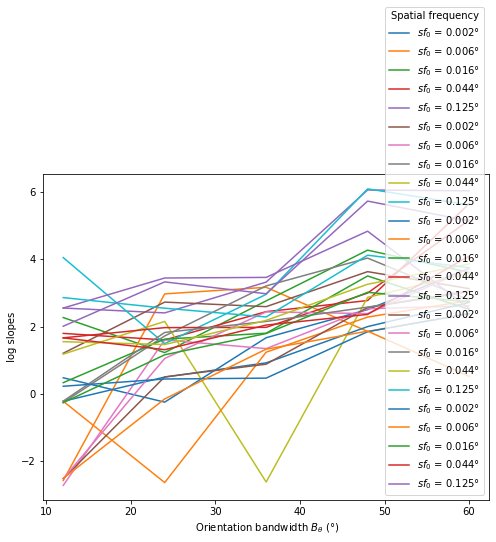

In [35]:
plt.figure(figsize = (8,6)) 

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        plt.plot(B_theta_list, np.log(wt__), label = r'$sf_0$ = %.3f°' %sf)
plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
plt.ylabel(r' log slopes ')
plt.legend(loc ='lower right',title="Spatial frequency")


In [36]:
np.corrcoef(B_theta_list, np.log(wt__))
np.sqrt(0.91567273)

0.9569079004794557

--> observer num 0
slope = 1.611, 0.781, 5.297, 12.217, 41.807, 0.076, 19.500, 23.714, 6.390, 10.802, 9.648, 3.407, 15.845, 71.493, 36.962, 6.024, 4.961, 11.504, 15.993, 283.839, 12.808, 11.080, 27.691, 427.653, 417.179
p0 = 0.100


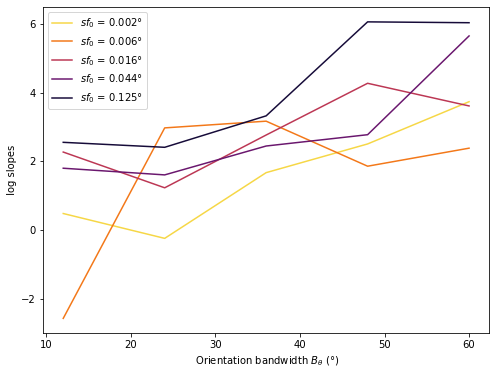

--> observer num 1
slope = 3.343, 15.271, 13.338, 37.754, 22.812, 0.066, 4.970, 3.833, 12.539, 13.664, 0.773, 5.585, 24.704, 56.501, 16.323, 3.256, 8.598, 0.073, 17.581, 35.982, 57.324, 4.449, 19.236, 442.122, 273.996
p0 = 0.207


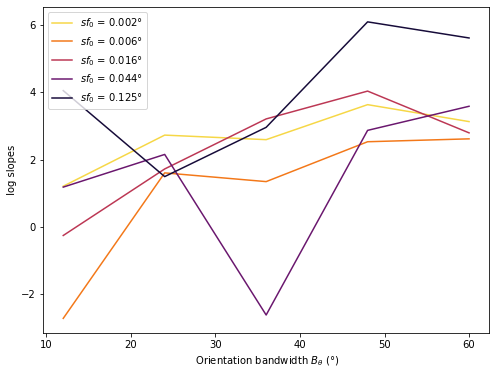

--> observer num 2
slope = 0.802, 1.644, 2.510, 7.369, 15.118, 0.802, 0.072, 3.445, 9.777, 16.005, 1.393, 5.081, 6.057, 33.206, 12.282, 5.278, 7.151, 7.213, 19.988, 174.542, 12.804, 31.248, 31.835, 125.647, 12.678
p0 = 0.045


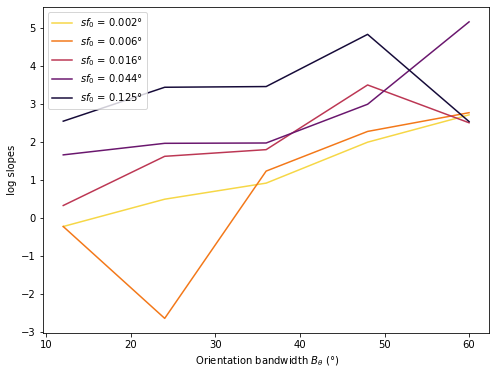

--> observer num 3
slope = 0.080, 1.654, 2.413, 13.016, 20.859, 0.080, 2.861, 11.419, 10.855, 41.259, 0.805, 6.192, 8.596, 13.160, 21.236, 4.711, 4.327, 8.871, 25.954, 47.389, 17.465, 12.742, 9.818, 61.551, 42.535
p0 = 0.037


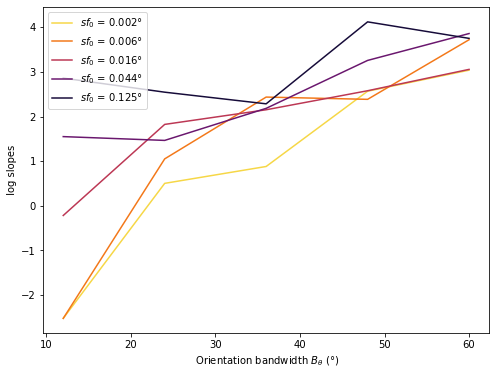

--> observer num 4
slope = 1.252, 1.553, 1.594, 6.339, 10.860, 0.081, 0.860, 3.771, 6.441, 1.683, 0.769, 3.187, 6.005, 20.430, 15.394, 5.270, 3.713, 7.714, 10.596, 59.884, 7.456, 27.847, 19.570, 307.387, 171.091
p0 = 0.131


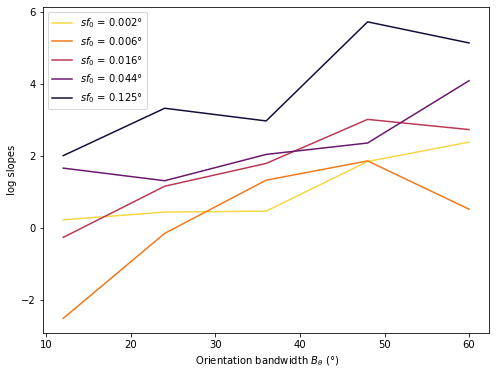

In [42]:
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    coef_list = []
    colors = plt.cm.inferno(np.linspace(.9, .1, len(B_theta_list)))
    plt.figure(figsize = (8,6)) 
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        plt.plot(B_theta_list, np.log(wt__),label = r'$sf_0$ = %.3f°' %sf, color=colors[i_sf])
    plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
    plt.ylabel(r' log slopes ')
    plt.legend(loc ='upper left') 
    plt.show()

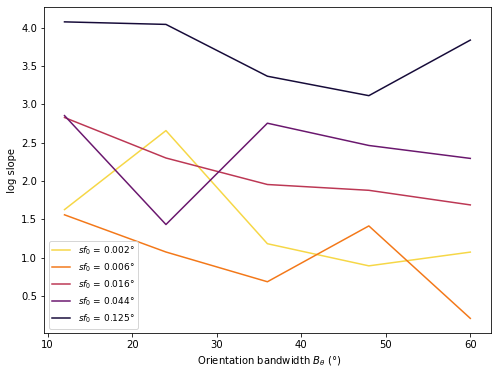

In [15]:
#cols = plt.cm.viridis(np.linspace(.2, .8, len(sf_list)))
plt.figure(figsize=(8,6))
for i_sf, sf in enumerate(sf_list) :
    sf_lst = []
    colors = plt.cm.inferno(np.linspace(.9, .1, len(B_theta_list)))

    for num, data in enumerate(subj_data_list) :
        theta0_, wt_, p0_ = get_params(results[num], verbose=False)
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        sf_lst.append(np.log(wt__))
    
        mean = np.mean(sf_lst, axis = 1)
        std = np.std(sf_lst, axis = 1)
    
    plt.plot(B_theta_list, mean, label=r'$sf_0$ = %.3f°' %sf, color=colors[i_sf])
    #plt.fill_between(B_theta_list, y1 = mean - std, y2 = mean + std, color = cols[i_sf])
    plt.legend(loc="best",fontsize='9');
    plt.xlabel(r' Orientation bandwidth $B_\theta$ (°)')
    plt.ylabel(r' log slope ')

--> observer num 0
slope = 1.611, 0.781, 5.297, 12.217, 41.807, 0.076, 19.500, 23.714, 6.390, 10.802, 9.648, 3.407, 15.845, 71.493, 36.962, 6.024, 4.961, 11.504, 15.993, 283.839, 12.808, 11.080, 27.691, 427.653, 417.179
p0 = 0.100


TypeError: 'AxesSubplot' object is not subscriptable

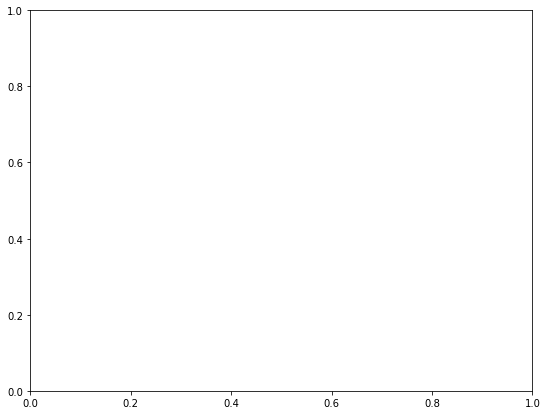

In [24]:
fig, axs = plt.subplots(1,len(subj_data_list), figsize=(9,7)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        correct = .5+ .5*np.exp(-wt__)
        axs[num].plot(B_theta_list, correct*100,label = r'$sf_0$ = %.3f°' %sf)
    axs[num].set_xlabel(r' $B_\theta$ (°)')
    axs[num].set_ylabel(r' % correct ')
    axs[num].legend(loc ='upper right');
   

--> observer num 0
slope = 1.611, 0.781, 5.297, 12.217, 41.807, 0.076, 19.500, 23.714, 6.390, 10.802, 9.648, 3.407, 15.845, 71.493, 36.962, 6.024, 4.961, 11.504, 15.993, 283.839, 12.808, 11.080, 27.691, 427.653, 417.179
p0 = 0.100


TypeError: 'AxesSubplot' object is not subscriptable

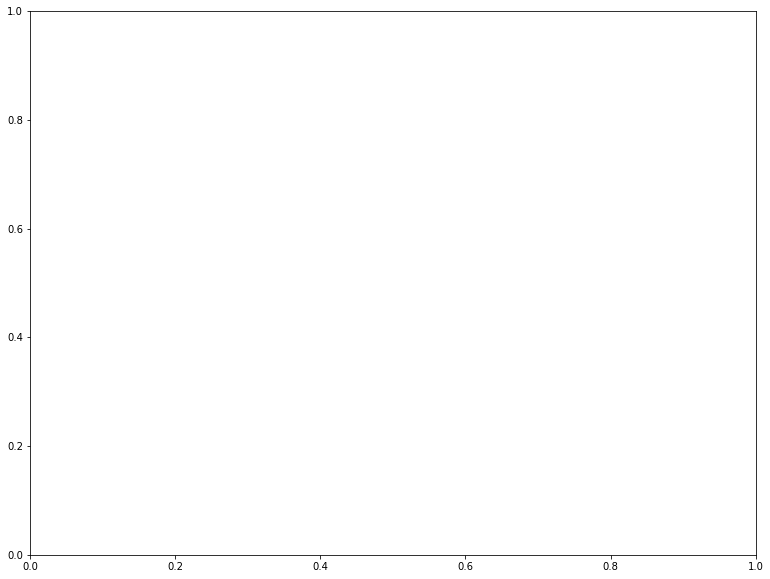

In [25]:
fig, axs = plt.subplots(1, len(subj_data_list), figsize=(13,10)) 
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    coef_list = []
    for i_sf, sf in enumerate(sf_list):
        wt__ = wt_[(i_sf*len(B_theta_list)):((i_sf+1)*len(B_theta_list))]
        axs[num].plot(B_theta_list, np.log(wt__), label=f'sf={sf:.3f}°')
    axs[num].set_xlabel(r'$B_\theta$ (°)')
    axs[num].set_ylabel(r'log slopes')
    axs[num].legend(loc ='lower right') 
    #axs[num].set_xscale('log')